In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np

In [72]:
week_days_path = "./paris_weekdays.csv"
week_ends_path = "./paris_weekends.csv"

paris_weekdays = pd.read_csv(week_days_path, index_col=0)
paris_weekends = pd.read_csv(week_ends_path, index_col=0)

paris_weekdays['is_weekend'] = 0
paris_weekends['is_weekend'] = 1

paris_all = pd.concat([paris_weekdays, paris_weekends], ignore_index=True)

print("Shape of combined dataset:", paris_all.shape)
print("Missing values:\n", paris_all.isnull().sum())


Shape of combined dataset: (6688, 20)
Missing values:
 realSum                       0
room_type                     0
room_shared                   0
room_private                  0
person_capacity               0
host_is_superhost             0
multi                         0
biz                           0
cleanliness_rating            0
guest_satisfaction_overall    0
bedrooms                      0
dist                          0
metro_dist                    0
attr_index                    0
attr_index_norm               0
rest_index                    0
rest_index_norm               0
lng                           0
lat                           0
is_weekend                    0
dtype: int64


In [73]:
print(paris_all.head())

      realSum        room_type  room_shared  room_private  person_capacity  \
0  296.159940     Private room        False          True              2.0   
1  288.237487     Private room        False          True              2.0   
2  211.343089     Private room        False          True              2.0   
3  298.956100  Entire home/apt        False         False              2.0   
4  247.926181  Entire home/apt        False         False              4.0   

   host_is_superhost  multi  biz  cleanliness_rating  \
0               True      0    0                10.0   
1               True      0    0                10.0   
2              False      0    0                10.0   
3              False      0    1                 9.0   
4              False      0    0                 7.0   

   guest_satisfaction_overall  bedrooms      dist  metro_dist  attr_index  \
0                        97.0         1  0.699821    0.193709  518.478947   
1                        97.0         1 

In [74]:
paris_all.shape

(6688, 20)

# Missing values

In [75]:
print(paris_all.isnull().sum())

realSum                       0
room_type                     0
room_shared                   0
room_private                  0
person_capacity               0
host_is_superhost             0
multi                         0
biz                           0
cleanliness_rating            0
guest_satisfaction_overall    0
bedrooms                      0
dist                          0
metro_dist                    0
attr_index                    0
attr_index_norm               0
rest_index                    0
rest_index_norm               0
lng                           0
lat                           0
is_weekend                    0
dtype: int64


In [76]:
print(paris_all.isnull().sum())

realSum                       0
room_type                     0
room_shared                   0
room_private                  0
person_capacity               0
host_is_superhost             0
multi                         0
biz                           0
cleanliness_rating            0
guest_satisfaction_overall    0
bedrooms                      0
dist                          0
metro_dist                    0
attr_index                    0
attr_index_norm               0
rest_index                    0
rest_index_norm               0
lng                           0
lat                           0
is_weekend                    0
dtype: int64


No missing values??? :)

# Standaryzacja

In [77]:
selected_columns = [
    'guest_satisfaction_overall',
    'dist',
    'realSum'
]

In [78]:
def remove_outliers(data, columns):
    filtered_data = data.copy()
    outlier_mask = pd.Series([True] * len(filtered_data))

    for col in columns:
        Q1 = filtered_data[col].quantile(0.25)
        Q3 = filtered_data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        outlier_mask &= (filtered_data[col] >= lower_bound) & (filtered_data[col] <= upper_bound)

    filtered_data = filtered_data[outlier_mask]
    removed_count = len(data) - len(filtered_data)
    print(f"Removed {removed_count} outliers ({removed_count/len(data)*100:.2f}%)")
    print(f"Remaining data: {len(filtered_data)} rows")

    return filtered_data

paris_all_clean = remove_outliers(paris_all, selected_columns)

Removed 232 outliers (3.47%)
Remaining data: 6456 rows


Combined dataset after standardization:
       guest_satisfaction_overall          dist       realSum
count                6.456000e+03  6.456000e+03  6.456000e+03
mean                 7.946280e-16  1.937043e-16 -3.257755e-16
std                  1.000077e+00  1.000077e+00  1.000077e+00
min                 -4.279622e+00 -2.005350e+00 -1.478276e+00
25%                 -5.252568e-01 -7.974754e-01 -6.939185e-01
50%                  1.967365e-01  2.481564e-03 -2.846883e-01
75%                  7.743311e-01  7.220513e-01  4.377798e-01
max                  1.063128e+00  3.227402e+00  4.113273e+00


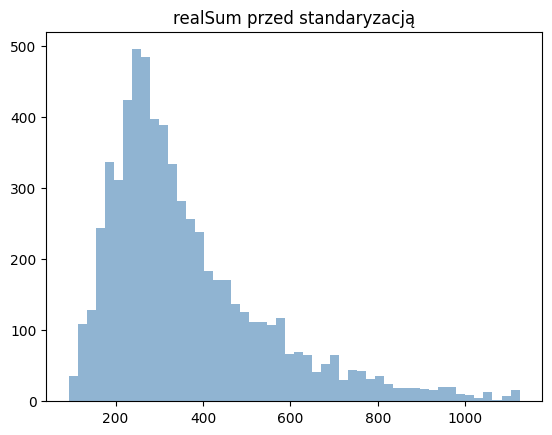

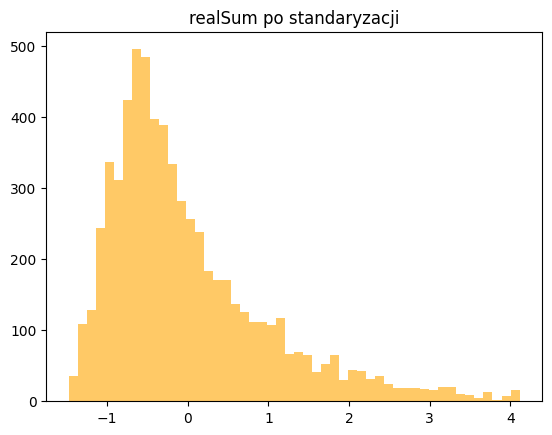

In [79]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
paris_all_std = paris_all_clean.copy()
paris_all_std[selected_columns] = scaler.fit_transform(paris_all_clean[selected_columns])

print("Combined dataset after standardization:")
print(paris_all_std[selected_columns].describe())

plt.hist(paris_all_clean['realSum'], bins=50, alpha=0.6, color='steelblue')
plt.title("realSum przed standaryzacją")
plt.show()

plt.hist(paris_all_std['realSum'], bins=50, alpha=0.6, color='orange')
plt.title("realSum po standaryzacji")
plt.show()

# Korelacja

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
def analyze_correlations_with_outlier_filter(df, selected_columns):
    target = 'realSum'
    variables = [c for c in selected_columns if c != target]

    print(f"\nCorrelation Analysis for Combined Dataset")

    correlations = {}
    for var in variables:
        corr = df[target].corr(df[var])
        correlations[var] = corr
        print(f"{target} vs {var:30} : {corr:+.4f}")

    realSum_threshold = df[target].quantile(0.95)
    df_filtered_all = df[df[target] <= realSum_threshold].copy()

    fig, axes = plt.subplots(1, len(variables), figsize=(7 * len(variables), 5))
    if len(variables) == 1:
        axes = [axes]

    for idx, var in enumerate(variables):
        ax = axes[idx]

        var_threshold = df_filtered_all[var].quantile(0.95)
        df_filtered = df_filtered_all[df_filtered_all[var] <= var_threshold].copy()

        sns.scatterplot(
            data=df_filtered,
            x=var,
            y=target,
            alpha=0.6,
            s=40,
            ax=ax
        )

        ax.set_xlabel(var, fontsize=11, fontweight='bold')
        ax.set_ylabel(target, fontsize=11, fontweight='bold')

        corr_val = correlations[var]
        ax.text(
            0.05, 0.95,
            f'r = {corr_val:+.3f}',
            transform=ax.transAxes,
            fontsize=12,
            fontweight='bold',
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9)
        )

        ax.grid(True, alpha=0.3, linestyle='--')

    plt.suptitle(
        f'Correlation Analysis: Combined Dataset\n(Filtered: top 5% outliers removed)',
        fontsize=15,
        fontweight='bold',
        y=1.05
    )
    plt.tight_layout()
    plt.show()

    return correlations


Correlation Analysis for Combined Dataset
realSum vs guest_satisfaction_overall     : +0.0728
realSum vs dist                           : -0.2078


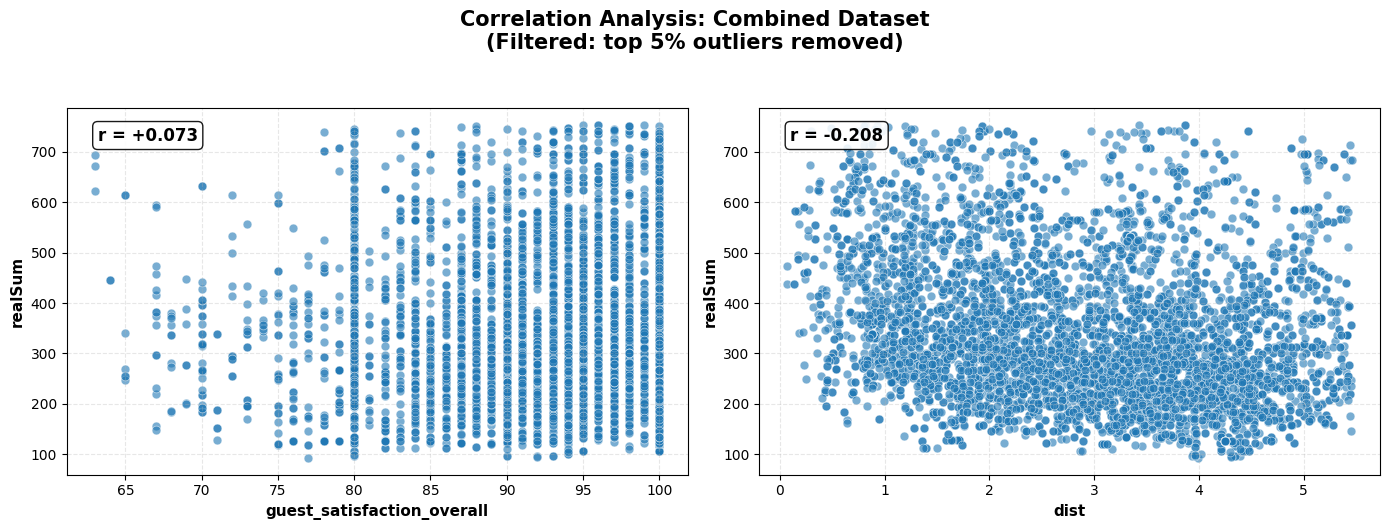

In [81]:

correlations_all = analyze_correlations_with_outlier_filter(paris_all_clean, selected_columns)

corr_val: 0.06429768149711608
corr_val: 0.0535867380005233
corr_val: 0.045665694708080955


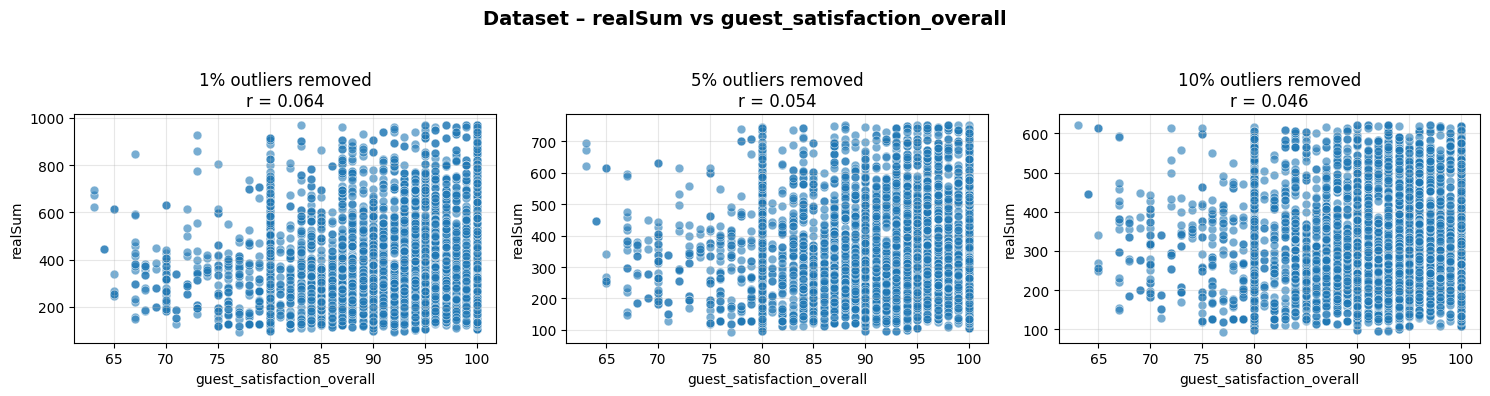

corr_val: -0.22469959661455363
corr_val: -0.23305524292508917
corr_val: -0.28678643146352095


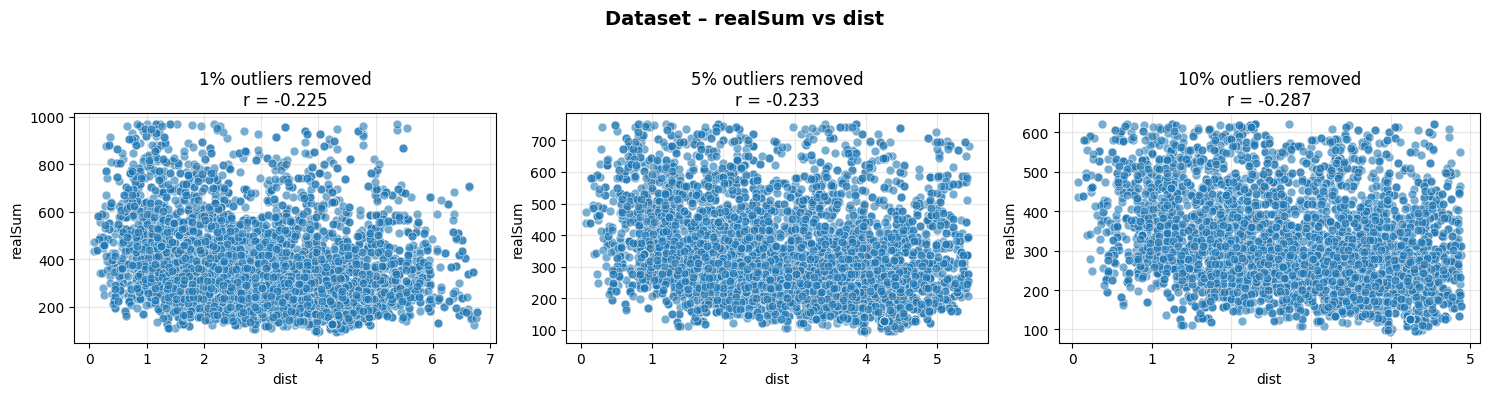

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_multiple_correlations(df, selected_columns, outlier_percents=[0.01, 0.05, 0.10], dataset_name="Dataset"):
    """
    Tworzy wykresy korelacji realSum vs inne zmienne z różnym % odrzuconych outlierów.
    df: DataFrame
    selected_columns: lista kolumn do analizy, musi zawierać 'realSum'
    outlier_percents: lista % próbek do odrzucenia
    dataset_name: nazwa zestawu danych (weekdays/weekends)
    """
    target = 'realSum'
    variables = [c for c in selected_columns if c != target]

    for var in variables:
        plt.figure(figsize=(15, 4))
        for idx, perc in enumerate(outlier_percents, 1):
            x_thresh = df[var].quantile(1 - perc)
            y_thresh = df[target].quantile(1 - perc)
            df_filtered = df[(df[var] <= x_thresh) & (df[target] <= y_thresh)]
            
            corr_val = df_filtered[var].corr(df_filtered[target])
            print('corr_val:', corr_val)
            
            plt.subplot(1, len(outlier_percents), idx)
            sns.scatterplot(data=df_filtered, x=var, y=target, alpha=0.6, s=40)
            plt.title(f'{perc*100:.0f}% outliers removed\nr = {corr_val:.3f}')
            plt.xlabel(var)
            plt.ylabel(target)
            plt.grid(True, alpha=0.3)
        
        plt.suptitle(f'{dataset_name} – {target} vs {var}', fontsize=14, fontweight='bold')
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

plot_multiple_correlations(paris_all_clean, selected_columns, outlier_percents=[0.01, 0.05, 0.10])

Wnioski

realSum vs guest_satisfaction_overall
- Korelacja praktycznie zerowa, niezależnie od odrzucenia 1%, 5% czy 10% próbek.
- Ceny hoteli nie są istotnie związane z ocenami satysfakcji gości.
- Najlepszy % odrzuconych outlierów: 5% – kompromis między zachowaniem większości danych a stabilnością korelacji.

realSum vs dist
- Słaba do umiarkowanej korelacja ujemna, która rośnie przy usunięciu większej liczby outlierów.
- Im bliżej centrum, tym cena obiektu wzrasta. Wzrost % odrzuconych outlierów lekko wzmacnia korelację, co pokazuje wpływ skrajnych wartości.
- Najlepszy % odrzuconych outlierów: 5% – kompromis między zachowaniem większości danych a stabilnością korelacji.

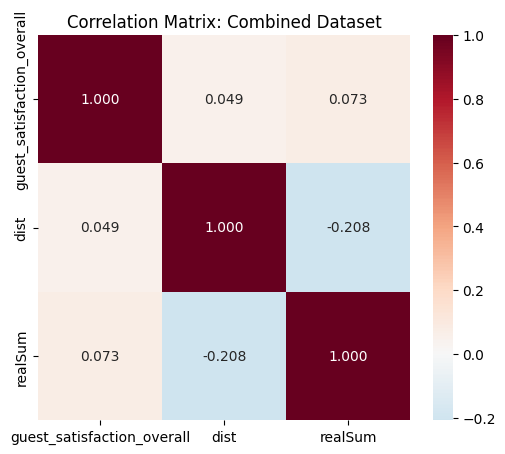

In [83]:
plt.figure(figsize=(6,5))
sns.heatmap(paris_all_clean[selected_columns].corr(), annot=True, fmt=".3f", cmap='RdBu_r', center=0)
plt.title("Correlation Matrix: Combined Dataset")
plt.show()

# Estymator jadrowy

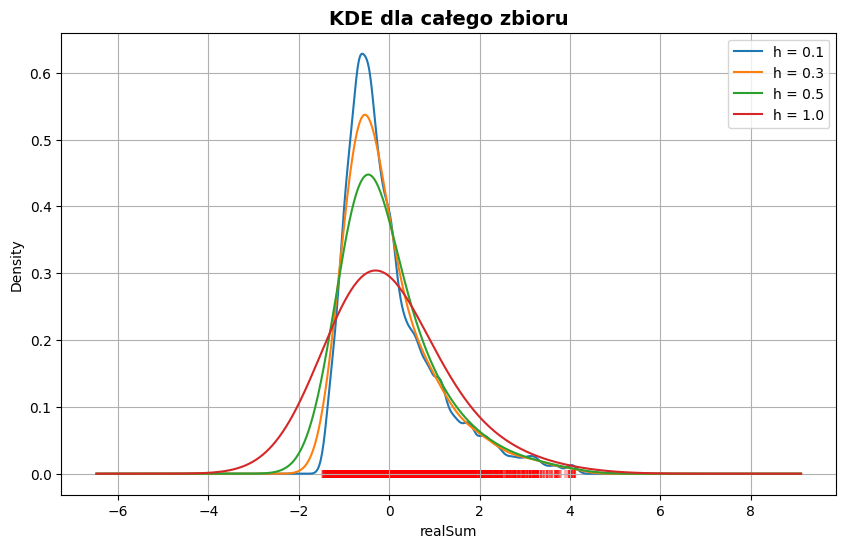

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import math

def K(x):
    return 1 / (math.sqrt(2 * math.pi)) * np.exp(-0.5 * x**2)

def kde(x_all, x, h):
    m = len(x_all)
    sum_k = sum(K((x - xi) / h) for xi in x_all)
    return sum_k / (m * h)

def plot_kde_with_bandwidths(data, h_values, title):
    x_min, x_max = data.min() - 5, data.max() + 5
    x_plot = np.linspace(x_min, x_max, 1000)
    
    plt.figure(figsize=(10,6))
    
    for h in h_values:
        y_plot = [kde(data, xi, h) for xi in x_plot]
        plt.plot(x_plot, y_plot, label=f'h = {h}')
    
    plt.scatter(data, np.zeros_like(data), color='red', alpha=0.3, marker='|')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('realSum')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

h_values = [0.1, 0.3, 0.5, 1.0]
plot_kde_with_bandwidths(paris_all_std['realSum'].values, h_values, "KDE dla całego zbioru")

# Outlier analysis

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from numpy.linalg import inv

def get_outlier_rows(df, col, z_thresh=3):
    mean = df[col].mean()
    std = df[col].std()
    z_scores = (df[col] - mean) / std
    return df[np.abs(z_scores) > z_thresh]

def mahalanobis_outliers(df, cols, threshold=0.99):
    data = df[cols].values
    mean = np.mean(data, axis=0)
    cov = np.cov(data, rowvar=False)
    inv_covmat = inv(cov)
    diff = data - mean
    m_dist = np.sqrt(np.sum(diff @ inv_covmat * diff, axis=1))
    
    critical_value = np.sqrt(chi2.ppf(threshold, df=len(cols)))
    outlier_mask = m_dist > critical_value
    return df[outlier_mask], m_dist

def plot_distribution_with_outliers(df, col):
    plt.figure(figsize=(8,4))
    plt.hist(df[col], bins=50, alpha=0.7, color='steelblue')
    outliers = get_outlier_rows(df, col)
    if len(outliers) > 0:
        plt.scatter(outliers[col], [0]*len(outliers), color='red', label='Outliers', zorder=10)
    plt.title(f'Distribution with Outliers: {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    return df[col].describe()


Analyzing column: guest_satisfaction_overall
Found 85 outlier rows
     guest_satisfaction_overall      dist     realSum
72                         65.0  0.187260  340.432473
78                         69.0  0.800433  448.317644
102                        68.0  1.105269  355.578339
163                        71.0  0.883245  339.500419
338                        70.0  1.228140  183.148476


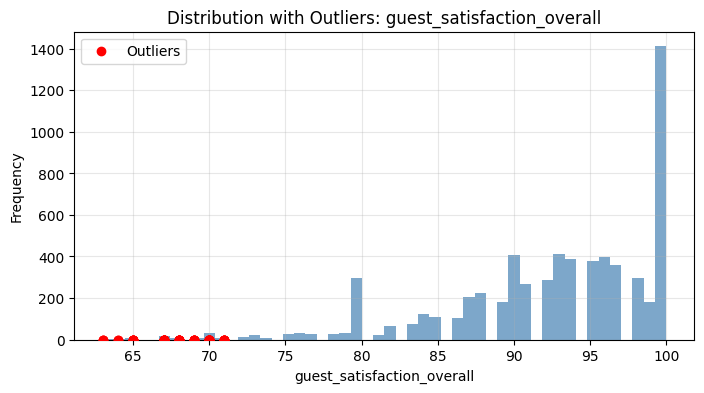


Analyzing column: dist
Found 15 outlier rows
      guest_satisfaction_overall      dist     realSum
2467                        86.0  7.557054  248.392208
2468                       100.0  7.398353  253.518501
2586                        94.0  7.474171  354.646286
2597                        95.0  7.679992  695.544785
2600                        87.0  7.703737  463.696523


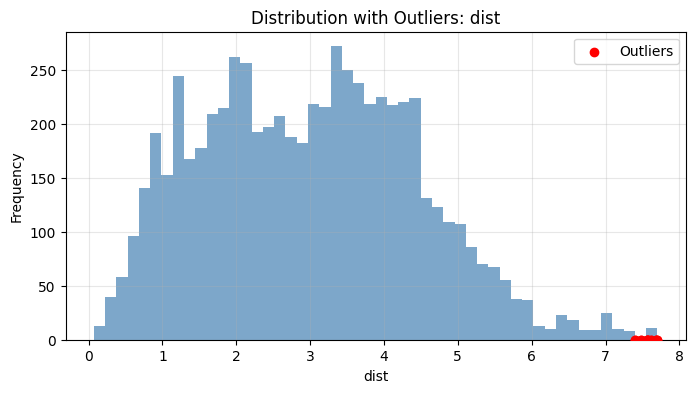


Analyzing column: realSum
Found 119 outlier rows
    guest_satisfaction_overall      dist     realSum
27                        97.0  1.004781  968.403393
28                        97.0  1.160891  968.403393
57                        95.0  1.164846  921.101687
67                        96.0  3.275414  973.762699
85                       100.0  1.398949  970.966539


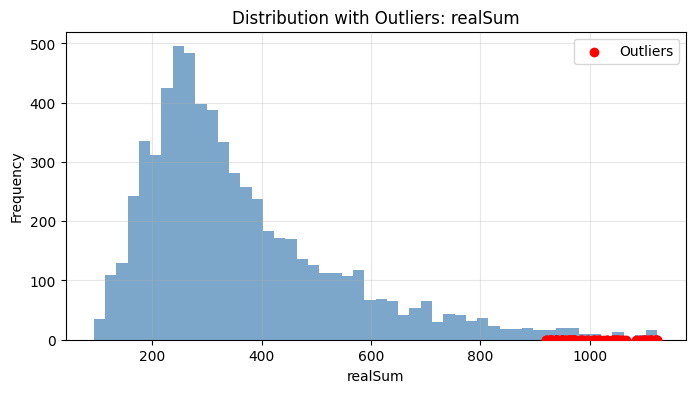

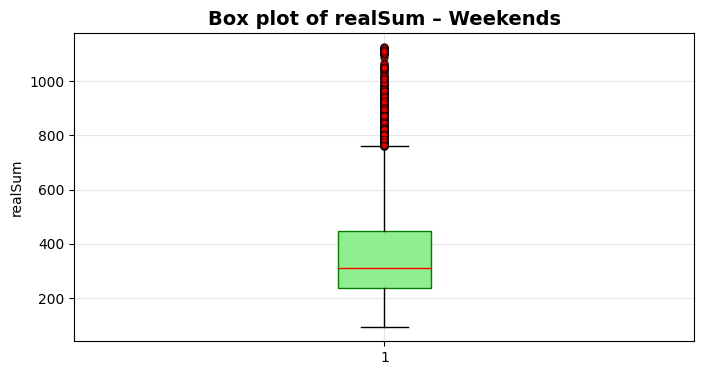


Multivariate Outlier Analysis: realSum vs dist
Number of outliers: 52 / 6456 (0.81%)


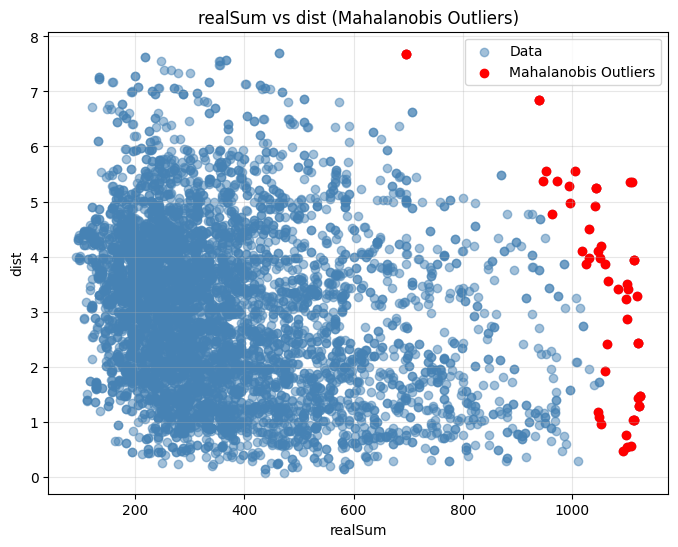


Multivariate Outlier Analysis: realSum vs guest_satisfaction_overall
Number of outliers: 66 / 6456 (1.02%)


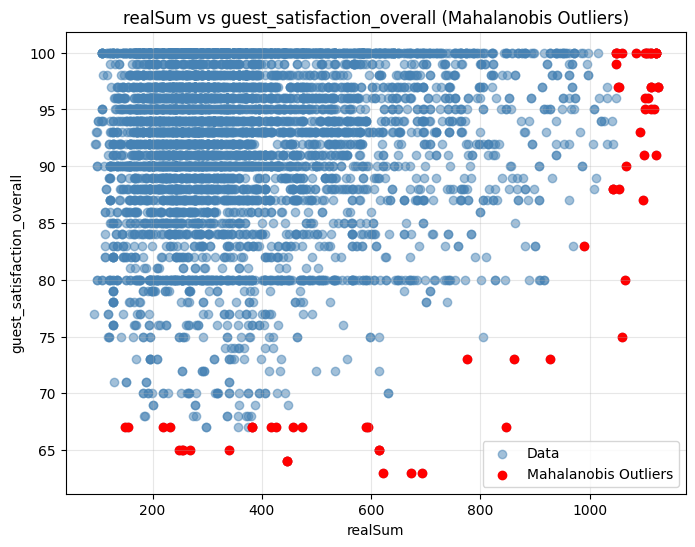

In [86]:
for col in selected_columns:
    print(f"\n{'='*40}\nAnalyzing column: {col}\n{'='*40}")
    outliers = get_outlier_rows(paris_all_clean, col)
    print(f"Found {len(outliers)} outlier rows")
    if len(outliers) > 0:
        print(outliers[selected_columns].head())
    plot_distribution_with_outliers(paris_all_clean, col)

plt.figure(figsize=(8,4))
plt.boxplot(paris_all_clean['realSum'], vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='green'),
            medianprops=dict(color='red'),
            flierprops=dict(marker='o', markerfacecolor='red', markersize=5, alpha=0.6))
plt.title('Box plot of realSum – Weekends', fontsize=14, fontweight='bold')
plt.ylabel('realSum')
plt.grid(True, alpha=0.3)
plt.show()

pairs = [
    ('realSum', 'dist'),
    ('realSum', 'guest_satisfaction_overall')
]

outliers_cache = {}

for x_var, y_var in pairs:
    print(f"\n{'='*60}")
    print(f"Multivariate Outlier Analysis: {x_var} vs {y_var}")
    print(f"{'='*60}")
    
    outliers, m_dist = mahalanobis_outliers(paris_all_clean, [x_var, y_var], threshold=0.999)
    outliers_cache[(x_var, y_var)] = outliers
    print(f"Number of outliers: {len(outliers)} / {len(paris_all_clean)} ({len(outliers)/len(paris_all_clean)*100:.2f}%)")
    
    plt.figure(figsize=(8,6))
    plt.scatter(paris_all_clean[x_var], paris_all_clean[y_var], c='steelblue', alpha=0.5, label='Data')
    plt.scatter(outliers[x_var], outliers[y_var], c='red', label='Mahalanobis Outliers')
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.title(f"{x_var} vs {y_var} (Mahalanobis Outliers)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Outlier analysis

### realSum vs guest_satisfaction_overall

In [87]:
print(outliers_cache[pairs[1]])

          realSum        room_type  room_shared  room_private  \
72     340.432473  Entire home/apt        False         False   
90    1059.977631  Entire home/apt        False         False   
182    776.167397  Entire home/apt        False         False   
184   1059.977631  Entire home/apt        False         False   
218   1121.260136     Private room        False          True   
...           ...              ...          ...           ...   
6118  1102.153043  Entire home/apt        False         False   
6209   148.662503     Private room        False          True   
6239  1053.220244  Entire home/apt        False         False   
6376  1109.143443  Entire home/apt        False         False   
6628   231.848262  Entire home/apt        False         False   

      person_capacity  host_is_superhost  multi  biz  cleanliness_rating  \
72                2.0              False      0    1                 9.0   
90                5.0              False      0    1               

In [88]:
outliers_df = outliers_cache[pairs[1]]

lowest_5 = outliers_df.nsmallest(7, 'realSum')
highest_5 = outliers_df.nlargest(7, 'realSum')

In [89]:
print("=== Lowest 5 realSum outliers ===")
print(lowest_5[['realSum', 'room_type', 'person_capacity', 'host_is_superhost', 
         'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 
         'dist', 'metro_dist', 'rest_index_norm', 'attr_index_norm']])

=== Lowest 5 realSum outliers ===
         realSum        room_type  person_capacity  host_is_superhost  \
6209  148.662503     Private room              2.0              False   
2681  155.652903     Private room              2.0              False   
3076  219.498555  Entire home/apt              2.0              False   
6628  231.848262  Entire home/apt              2.0              False   
1091  247.926181  Entire home/apt              2.0              False   
438   254.450555  Entire home/apt              2.0              False   
4350  255.382608  Entire home/apt              2.0              False   

      cleanliness_rating  guest_satisfaction_overall  bedrooms      dist  \
6209                 7.0                        67.0         1  6.676356   
2681                 7.0                        67.0         1  6.676334   
3076                 6.0                        67.0         1  3.773809   
6628                 6.0                        67.0         1  3.773806   
1

In [90]:
print("\n=== Highest 5 realSum outliers ===")
print(highest_5[['realSum', 'room_type', 'person_capacity', 'host_is_superhost', 
        'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 
        'dist', 'metro_dist', 'rest_index_norm', 'attr_index_norm']])


=== Highest 5 realSum outliers ===
          realSum        room_type  person_capacity  host_is_superhost  \
785   1124.289309  Entire home/apt              4.0               True   
3992  1124.289309  Entire home/apt              4.0               True   
910   1121.959176  Entire home/apt              4.0              False   
4135  1121.959176  Entire home/apt              4.0              False   
218   1121.260136     Private room              4.0               True   
3165  1121.260136  Entire home/apt              6.0              False   
3371  1121.260136     Private room              4.0               True   

      cleanliness_rating  guest_satisfaction_overall  bedrooms      dist  \
785                 10.0                        97.0         3  1.469270   
3992                10.0                        97.0         3  1.469263   
910                 10.0                       100.0         1  1.280177   
4135                10.0                       100.0         1  1.2

In [91]:
print("\n=== Summary Statistics ===")
print("\nLowest 5 - Mean values:")
print(lowest_5[['realSum', 'person_capacity', 'cleanliness_rating', 
         'guest_satisfaction_overall', 'bedrooms', 'dist', 
         'metro_dist', 'rest_index_norm', 'attr_index_norm']].mean())

print("\nHighest 5 - Mean values:")
print(highest_5[['realSum', 'person_capacity', 'cleanliness_rating', 
        'guest_satisfaction_overall', 'bedrooms', 'dist', 
        'metro_dist', 'rest_index_norm', 'attr_index_norm']].mean())


=== Summary Statistics ===

Lowest 5 - Mean values:
realSum                       216.203081
person_capacity                 2.000000
cleanliness_rating              7.857143
guest_satisfaction_overall     66.142857
bedrooms                        0.571429
dist                            3.964678
metro_dist                      0.212759
rest_index_norm                36.684490
attr_index_norm                15.316045
dtype: float64

Highest 5 - Mean values:
realSum                       1122.325340
person_capacity                  4.285714
cleanliness_rating               9.857143
guest_satisfaction_overall      97.857143
bedrooms                         2.142857
dist                             1.682382
metro_dist                       0.185086
rest_index_norm                 59.164928
attr_index_norm                 26.460685
dtype: float64


In [92]:
capacity_high = outliers_df.nlargest(7, 'person_capacity')

In [93]:
print("\nPerson capacity - highest:")
print(capacity_high[['realSum', 'person_capacity', 'cleanliness_rating', 
        'guest_satisfaction_overall', 'bedrooms', 'dist', 
        'metro_dist', 'rest_index_norm', 'attr_index_norm']])


Person capacity - highest:
          realSum  person_capacity  cleanliness_rating  \
754    847.236462              6.0                 9.0   
1525  1049.026004              6.0                10.0   
2498  1066.268991              6.0                 9.0   
2815  1118.463976              6.0                10.0   
3165  1121.260136              6.0                 9.0   
3449  1047.394911              6.0                10.0   
3573  1049.259018              6.0                 9.0   

      guest_satisfaction_overall  bedrooms      dist  metro_dist  \
754                         67.0         2  0.761304    0.386879   
1525                       100.0         2  1.717905    0.135937   
2498                        90.0         2  3.557564    0.244881   
2815                        95.0         2  3.277514    0.194505   
3165                        91.0         3  1.432813    0.206175   
3449                        99.0         2  1.171404    0.151149   
3573                       100.

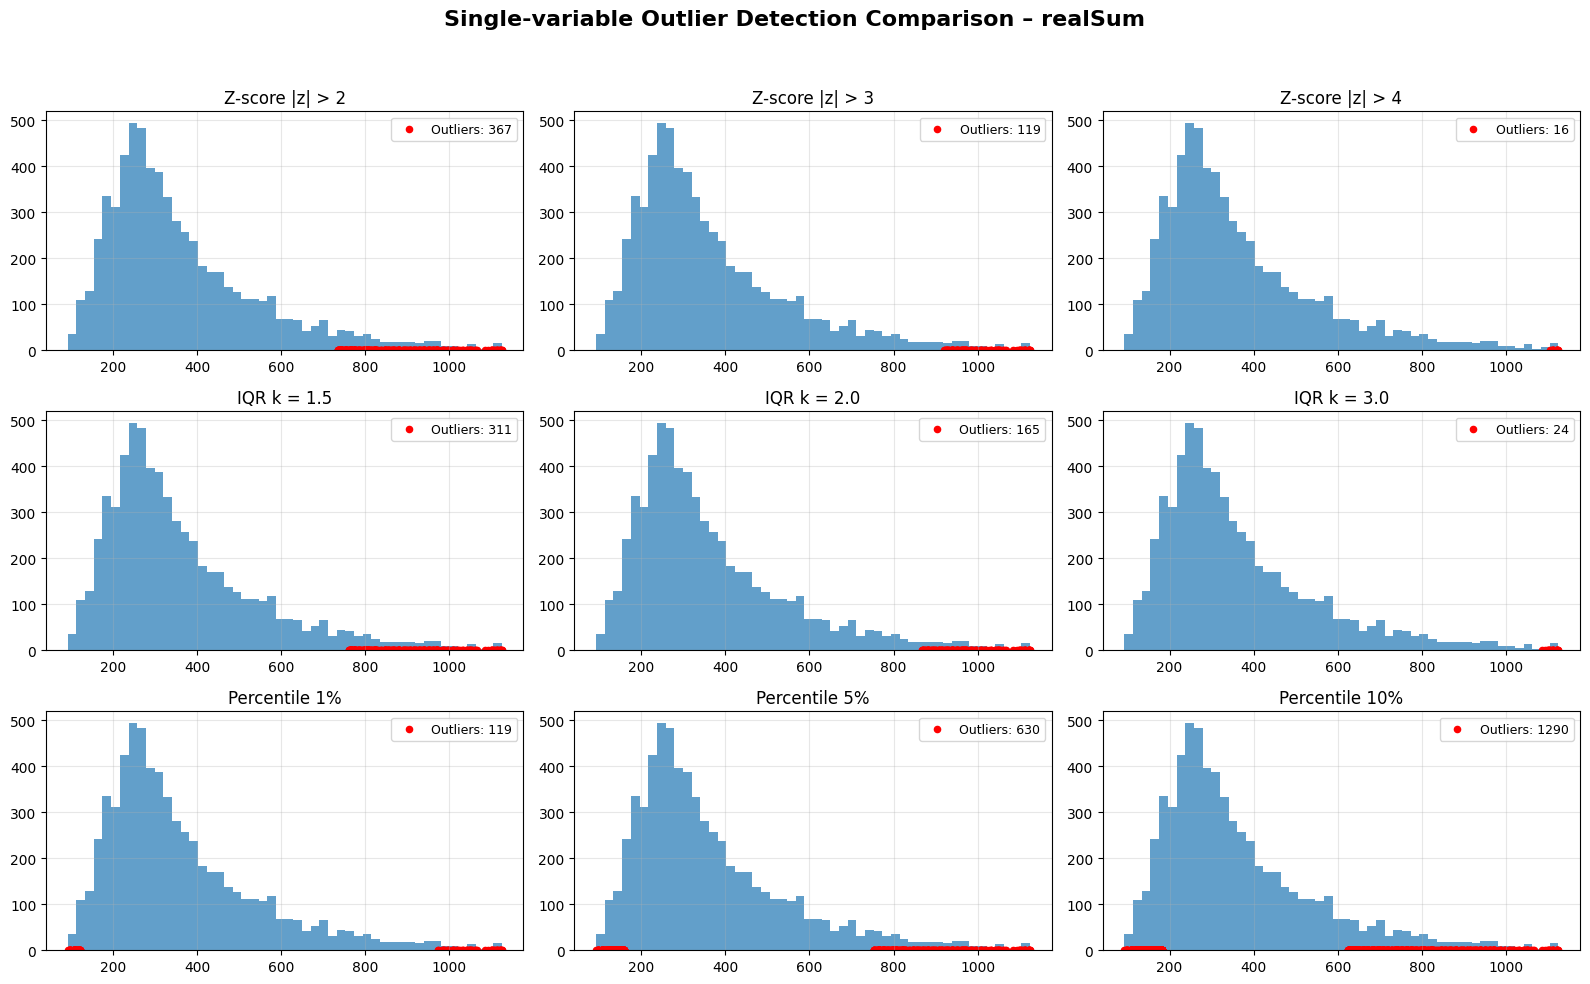

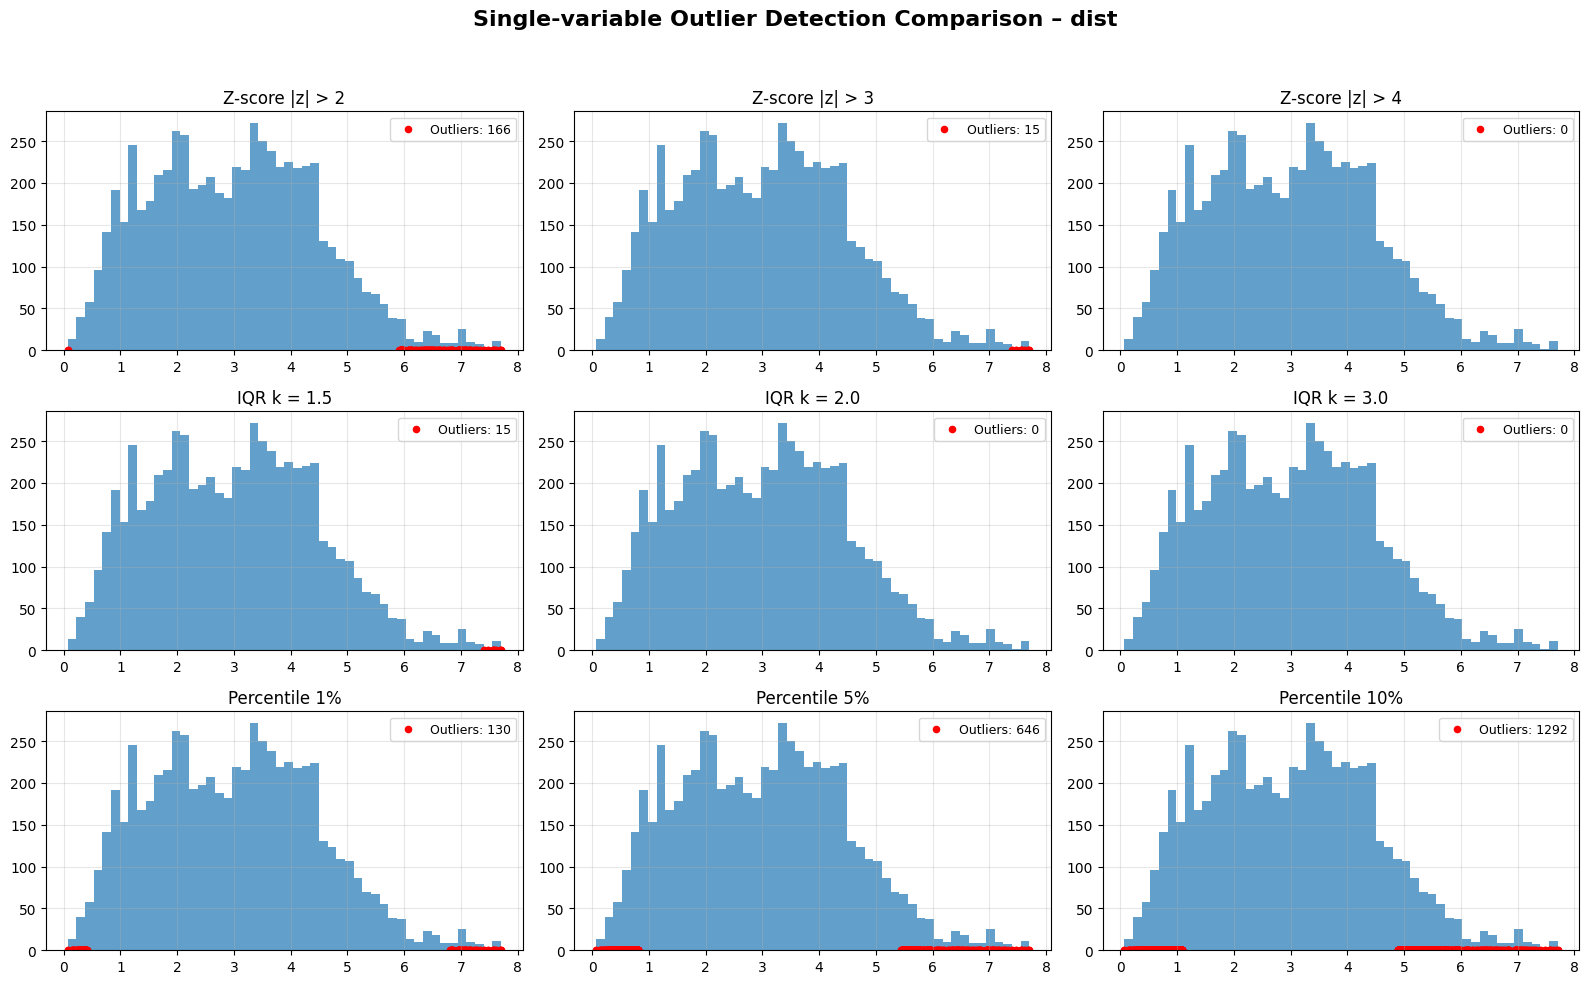

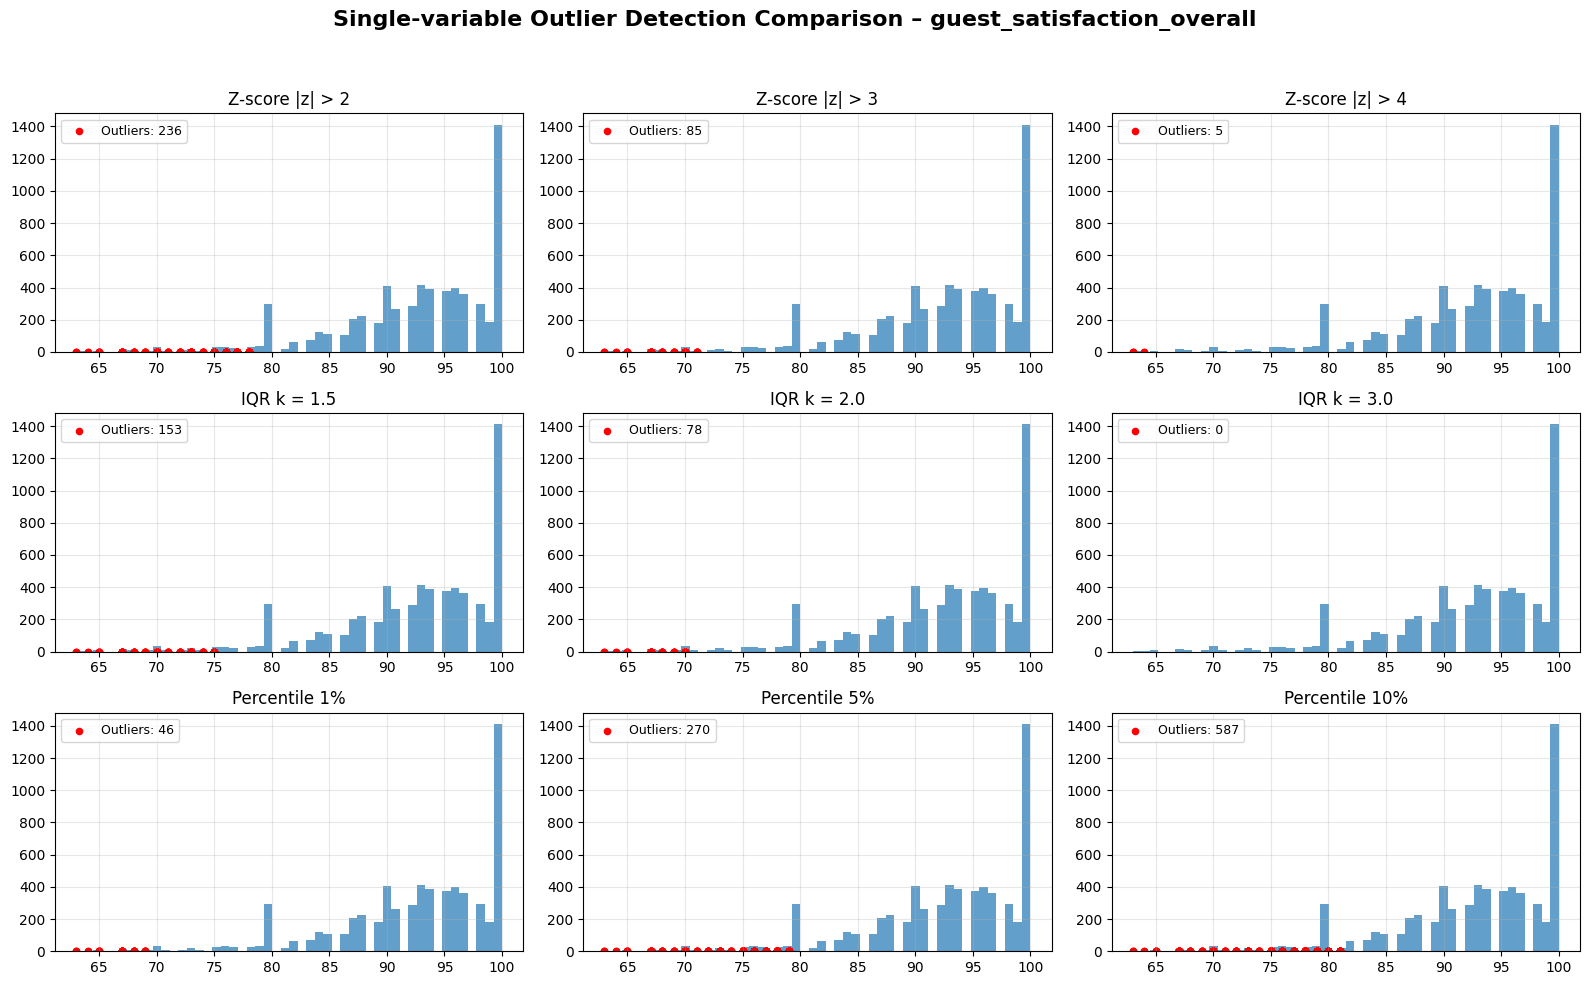

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def zscore_outliers(series, threshold):
    z = (series - series.mean()) / series.std()
    return np.abs(z) > threshold

def iqr_outliers(series, k):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - k * IQR
    upper = Q3 + k * IQR
    return (series < lower) | (series > upper)

def percentile_outliers(series, perc):
    lower = series.quantile(perc)
    upper = series.quantile(1 - perc)
    return (series < lower) | (series > upper)

def compare_outlier_methods(series, variable_name):
    methods = [
        ("Z-score |z| > 2", zscore_outliers(series, 2)),
        ("Z-score |z| > 3", zscore_outliers(series, 3)),
        ("Z-score |z| > 4", zscore_outliers(series, 4)),
        ("IQR k = 1.5", iqr_outliers(series, 1.5)),
        ("IQR k = 2.0", iqr_outliers(series, 2.0)),
        ("IQR k = 3.0", iqr_outliers(series, 3.0)),
        ("Percentile 1%", percentile_outliers(series, 0.01)),
        ("Percentile 5%", percentile_outliers(series, 0.05)),
        ("Percentile 10%", percentile_outliers(series, 0.10)),
    ]

    fig, axes = plt.subplots(3, 3, figsize=(16, 10))
    axes = axes.flatten()

    for ax, (title, mask) in zip(axes, methods):
        ax.hist(series, bins=50, alpha=0.7)
        ax.scatter(
            series[mask],
            np.zeros(mask.sum()),
            color='red',
            s=20,
            label=f'Outliers: {mask.sum()}'
        )
        ax.set_title(title)
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)

    fig.suptitle(
        f"Single-variable Outlier Detection Comparison – {variable_name}",
        fontsize=16,
        fontweight='bold'
    )
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

compare_outlier_methods(paris_all_clean['realSum'], 'realSum')
compare_outlier_methods(paris_all_clean['dist'], 'dist')
compare_outlier_methods(paris_all_clean['guest_satisfaction_overall'], 'guest_satisfaction_overall')

# Klasyfikacja

Classification Results:
Accuracy: 0.5271

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.05      0.08       618
           1       0.53      0.97      0.68       674

    accuracy                           0.53      1292
   macro avg       0.55      0.51      0.38      1292
weighted avg       0.55      0.53      0.40      1292

Confusion Matrix:
[[ 28 590]
 [ 21 653]]

Feature Importance (Logistic Regression Coefficients):
                   feature  coefficient
guest_satisfaction_overall     0.049460
                      dist    -0.045168
                   realSum    -0.044372


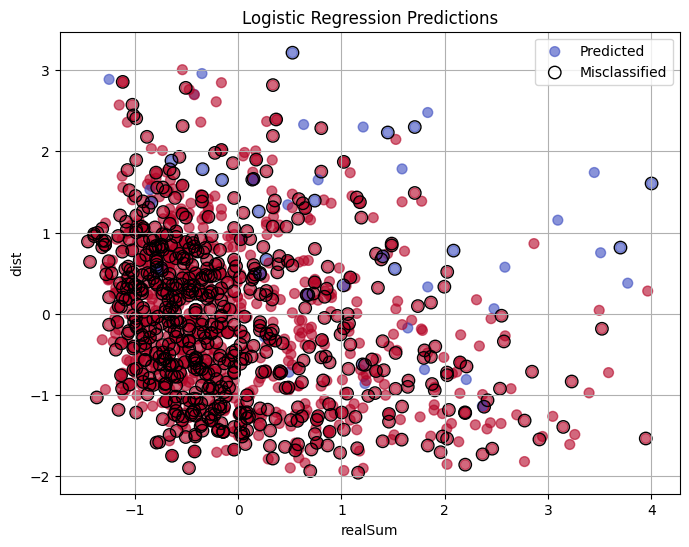

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X = paris_all_clean[['realSum', 'dist', 'guest_satisfaction_overall']]
y = paris_all_clean['is_weekend']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print("Classification Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

coefficients = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_[0]
})
coefficients['abs_coef'] = np.abs(coefficients['coefficient'])
coefficients = coefficients.sort_values('abs_coef', ascending=False)

print("\nFeature Importance (Logistic Regression Coefficients):")
print(coefficients[['feature', 'coefficient']].to_string(index=False))

plt.figure(figsize=(8,6))

X_plot = X_test_scaled[:, :2]
y_true = y_test.values
y_pred_plot = y_pred

plt.scatter(
    X_plot[:, 0], X_plot[:, 1],
    c=y_pred_plot,
    cmap='coolwarm',
    alpha=0.6,
    s=50,
    label='Predicted'
)

misclassified = y_pred_plot != y_true
plt.scatter(
    X_plot[misclassified, 0], X_plot[misclassified, 1],
    facecolors='none',
    edgecolors='black',
    s=80,
    label='Misclassified'
)

plt.xlabel('realSum')
plt.ylabel('dist')
plt.title('Logistic Regression Predictions')
plt.legend()
plt.grid(True)
plt.show()


Classification Results:
Accuracy: 0.5163

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.06      0.11       618
           1       0.52      0.93      0.67       674

    accuracy                           0.52      1292
   macro avg       0.49      0.50      0.39      1292
weighted avg       0.49      0.52      0.40      1292

Confusion Matrix:
[[ 38 580]
 [ 45 629]]

Feature Importance (Decision Tree):
                   feature  importance
                   realSum    0.599179
                      dist    0.349843
guest_satisfaction_overall    0.050978


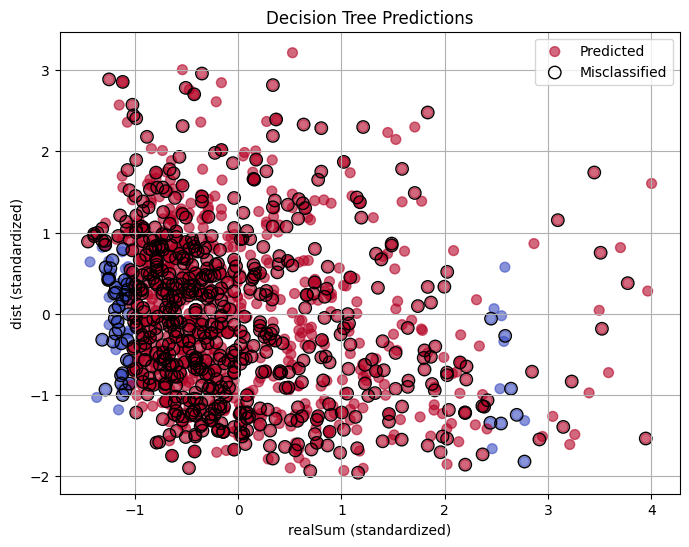

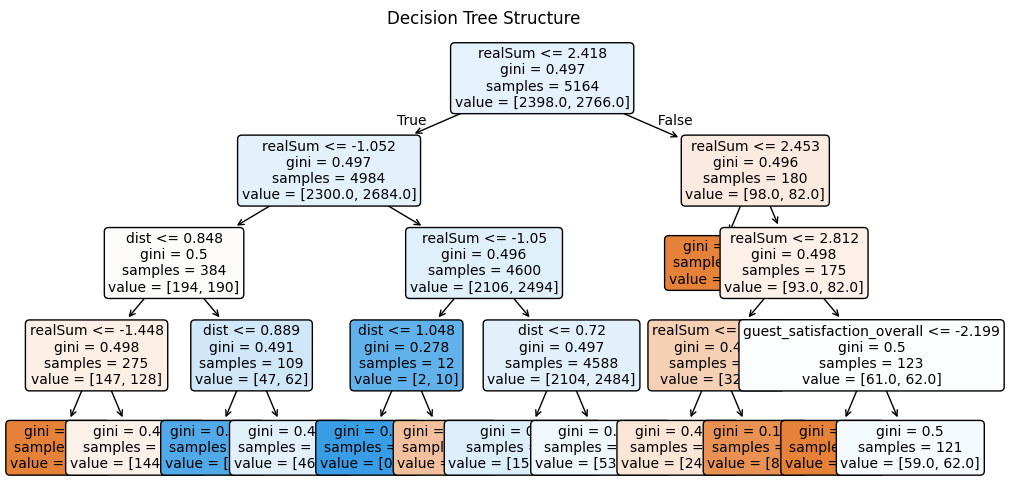

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X = paris_all_clean[['realSum', 'dist', 'guest_satisfaction_overall']]
y = paris_all_clean['is_weekend']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

print("Classification Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Decision Tree):")
print(feature_importance.to_string(index=False))

plt.figure(figsize=(8,6))

X_plot = X_test_scaled[:, :2]
y_true = y_test.values
y_pred_plot = y_pred

plt.scatter(
    X_plot[:, 0], X_plot[:, 1],
    c=y_pred_plot,
    cmap='coolwarm',
    alpha=0.6,
    s=50,
    label='Predicted'
)

misclassified = y_pred_plot != y_true
plt.scatter(
    X_plot[misclassified, 0], X_plot[misclassified, 1],
    facecolors='none',
    edgecolors='black',
    s=80,
    label='Misclassified'
)

plt.xlabel('realSum (standardized)')
plt.ylabel('dist (standardized)')
plt.title('Decision Tree Predictions')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,6))
plot_tree(clf, feature_names=X.columns,
          filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree Structure')
plt.show()


Wniosek:
Co było widoczne już na etapie korelacji – nie ma większej różnicy między weekday a weekend, zatem nie jest możliwe skuteczne rozróżnienie tych klas na podstawie użytych cech. Model przewiduje głównie dominantną klasę, co skutkuje wysokim recall dla weekendów i słabym dla dni roboczych.

## Klasyfikacja - host_is_superhost

Classification Results:
Accuracy: 0.8746

Classification Report:
              precision    recall  f1-score   support

       False       0.87      1.00      0.93      1130
        True       0.00      0.00      0.00       162

    accuracy                           0.87      1292
   macro avg       0.44      0.50      0.47      1292
weighted avg       0.76      0.87      0.82      1292

Confusion Matrix:
[[1130    0]
 [ 162    0]]

Feature Importance (Logistic Regression Coefficients):
                   feature  coefficient
guest_satisfaction_overall     1.070297
                      dist     0.056020
                   realSum     0.050086


/home/washindeiru/.venv/md/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/washindeiru/.venv/md/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/washindeiru/.venv/md/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

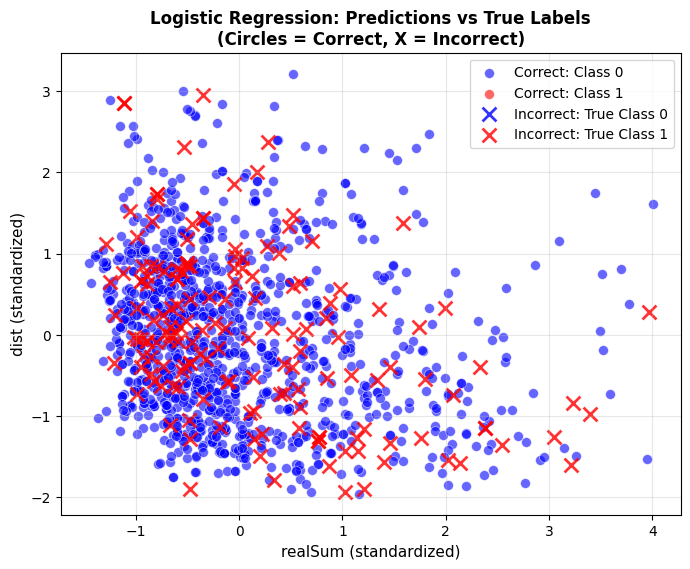

In [114]:
X = paris_all_clean[['realSum', 'dist', 'guest_satisfaction_overall']]
y = paris_all_clean['host_is_superhost']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print("Classification Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

coefficients = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_[0]
})
coefficients['abs_coef'] = np.abs(coefficients['coefficient'])
coefficients = coefficients.sort_values('abs_coef', ascending=False)

print("\nFeature Importance (Logistic Regression Coefficients):")
print(coefficients[['feature', 'coefficient']].to_string(index=False))

plt.figure(figsize=(8,6))

X_plot = X_test_scaled[:, :2]
y_true = y_test.values
y_pred_plot = y_pred

correct_mask = y_pred_plot == y_true
incorrect_mask = ~correct_mask

for class_label in [0, 1]:
    mask = correct_mask & (y_true == class_label)
    plt.scatter(
        X_plot[mask, 0], X_plot[mask, 1],
        c='blue' if class_label == 0 else 'red',
        alpha=0.6,
        s=50,
        marker='o',
        label=f'Correct: Class {class_label}',
        edgecolors='white',
        linewidth=0.5
    )

for class_label in [0, 1]:
    mask = incorrect_mask & (y_true == class_label)
    plt.scatter(
        X_plot[mask, 0], X_plot[mask, 1],
        c='blue' if class_label == 0 else 'red',
        alpha=0.8,
        s=100,
        marker='x',
        label=f'Incorrect: True Class {class_label}',
        linewidth=2
    )

plt.xlabel('realSum (standardized)', fontsize=11)
plt.ylabel('dist (standardized)', fontsize=11)
plt.title('Logistic Regression: Predictions vs True Labels\n(Circles = Correct, X = Incorrect)', fontsize=12, fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()


Classification Results:
Accuracy: 0.8831

Classification Report:
              precision    recall  f1-score   support

       False       0.89      0.99      0.94      1130
        True       0.65      0.15      0.24       162

    accuracy                           0.88      1292
   macro avg       0.77      0.57      0.59      1292
weighted avg       0.86      0.88      0.85      1292

Confusion Matrix:
[[1117   13]
 [ 138   24]]

Feature Importance (Decision Tree):
                   feature  importance
guest_satisfaction_overall    0.934196
                   realSum    0.047078
                      dist    0.018727


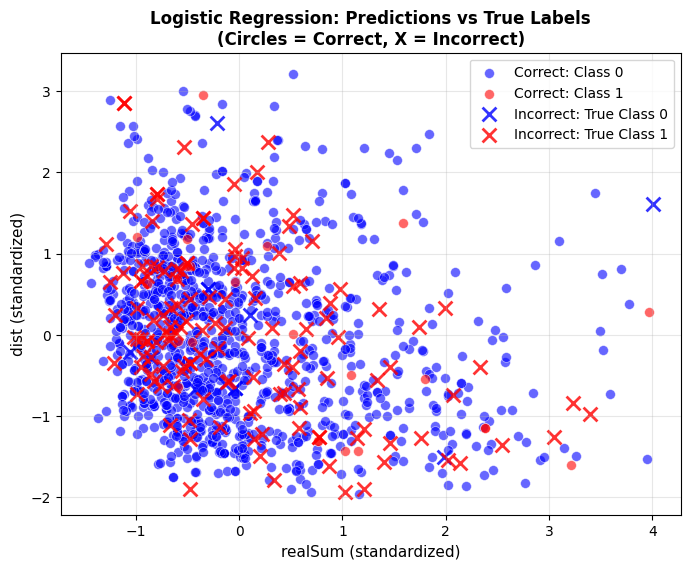

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X = paris_all_clean[['realSum', 'dist', 'guest_satisfaction_overall']]
y = paris_all_clean['host_is_superhost']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

print("Classification Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Decision Tree):")
print(feature_importance.to_string(index=False))

plt.figure(figsize=(8,6))

X_plot = X_test_scaled[:, :2]
y_true = y_test.values
y_pred_plot = y_pred

correct_mask = y_pred_plot == y_true
incorrect_mask = ~correct_mask

for class_label in [0, 1]:
    mask = correct_mask & (y_true == class_label)
    plt.scatter(
        X_plot[mask, 0], X_plot[mask, 1],
        c='blue' if class_label == 0 else 'red',
        alpha=0.6,
        s=50,
        marker='o',
        label=f'Correct: Class {class_label}',
        edgecolors='white',
        linewidth=0.5
    )

for class_label in [0, 1]:
    mask = incorrect_mask & (y_true == class_label)
    plt.scatter(
        X_plot[mask, 0], X_plot[mask, 1],
        c='blue' if class_label == 0 else 'red',
        alpha=0.8,
        s=100,
        marker='x',
        label=f'Incorrect: True Class {class_label}',
        linewidth=2
    )

plt.xlabel('realSum (standardized)', fontsize=11)
plt.ylabel('dist (standardized)', fontsize=11)
plt.title('Logistic Regression: Predictions vs True Labels\n(Circles = Correct, X = Incorrect)', fontsize=12, fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()


# Klasteryzacja

In [97]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def perform_clustering(data, n_clusters):
    if 'is_weekend' in data.columns:
        X = data[selected_columns].copy()
    else:
        X = data[selected_columns].copy()

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)

    return labels, kmeans, scaler

In [ ]:
labels_2, kmeans_2, scaler_2 = perform_clustering(paris_all_clean, n_clusters=2)
paris_all_clean['cluster_2'] = labels_2

labels_3, kmeans_3, scaler_3 = perform_clustering(paris_all_clean, n_clusters=3)
paris_all_clean['cluster_3'] = labels_3

labels_5, kmeans_5, scaler_5 = perform_clustering(paris_all_clean, n_clusters=5)
paris_all_clean['cluster_5'] = labels_5

print("\n=== 2 Clusters ===")
print(paris_all_clean.groupby('cluster_2')[['realSum', 'dist', 'guest_satisfaction_overall', 'is_weekend', 'host_is_superhost']].mean())
print(f"\nCluster sizes: {paris_all_clean['cluster_2'].value_counts().to_dict()}")

print("\n=== 3 Clusters ===")
print(paris_all_clean.groupby('cluster_3')[['realSum', 'dist', 'guest_satisfaction_overall', 'is_weekend', 'host_is_superhost']].mean())
print(f"\nCluster sizes: {paris_all_clean['cluster_3'].value_counts().to_dict()}")


=== 2 Clusters ===
              realSum      dist  guest_satisfaction_overall  is_weekend  \
cluster_2                                                                 
0          459.192525  1.835267                   92.041377    0.535915   
1          283.019345  4.017650                   93.161863    0.530131   

           host_is_superhost  
cluster_2                     
0                   0.135055  
1                   0.147307  

Cluster sizes: {1: 3435, 0: 3021}

=== 3 Clusters ===
              realSum      dist  guest_satisfaction_overall  is_weekend  \
cluster_3                                                                 
0          527.267495  1.861705                   95.526108    0.533005   
1          279.772382  3.904626                   95.340342    0.535808   
2          316.506455  2.662827                   82.441389    0.526049   

           host_is_superhost  
cluster_3                     
0                   0.183251  
1                   0.174113  


In [110]:
print("\n=== 5 Clusters ===")
print(paris_all_clean.groupby('cluster_5')[['realSum', 'dist', 'guest_satisfaction_overall', 'is_weekend', 'host_is_superhost']].mean())
print(f"\nCluster sizes: {paris_all_clean['cluster_3'].value_counts().to_dict()}")


=== 5 Clusters ===
              realSum      dist  guest_satisfaction_overall  is_weekend  \
cluster_5                                                                 
0          720.523602  2.331952                   95.163823    0.530148   
1          295.162744  4.263057                   97.046406    0.537068   
2          321.466454  1.874944                   95.374434    0.544036   
3          371.951780  2.001006                   80.484728    0.521912   
4          266.977308  4.233729                   86.751402    0.514953   

           host_is_superhost  
cluster_5                     
0                   0.172924  
1                   0.212224  
2                   0.178661  
3                   0.007968  
4                   0.024299  

Cluster sizes: {1: 3044, 0: 2030, 2: 1382}


In [99]:
def visualize_clusters(data, cluster_column, title):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    unique_clusters = sorted(data[cluster_column].unique())

    for cluster in unique_clusters:
        cluster_data = data[data[cluster_column] == cluster]
        axes[0].scatter(
            cluster_data['realSum'],
            cluster_data['dist'],
            label=f'Cluster {cluster}',
            alpha=0.6,
            edgecolors='white',
            linewidth=0.5
        )
    axes[0].set_xlabel('Price (realSum)')
    axes[0].set_ylabel('Distance')
    axes[0].set_title('Price vs Distance')
    axes[0].legend()

    for cluster in unique_clusters:
        cluster_data = data[data[cluster_column] == cluster]
        axes[1].scatter(
            cluster_data['realSum'],
            cluster_data['guest_satisfaction_overall'],
            label=f'Cluster {cluster}',
            alpha=0.6,
            edgecolors='white',
            linewidth=0.5
        )
    axes[1].set_xlabel('Price (realSum)')
    axes[1].set_ylabel('Guest Satisfaction')
    axes[1].set_title('Price vs Satisfaction')
    axes[1].legend()

    for cluster in unique_clusters:
        cluster_data = data[data[cluster_column] == cluster]
        axes[2].scatter(
            cluster_data['dist'],
            cluster_data['guest_satisfaction_overall'],
            label=f'Cluster {cluster}',
            alpha=0.6,
            edgecolors='white',
            linewidth=0.5
        )
    axes[2].set_xlabel('Distance')
    axes[2].set_ylabel('Guest Satisfaction')
    axes[2].set_title('Distance vs Satisfaction')
    axes[2].legend()

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

In [100]:
labels_2, kmeans_2, scaler_2 = perform_clustering(paris_all_clean, n_clusters=2)
paris_all_clean['cluster_2'] = labels_2

labels_3, kmeans_3, scaler_3 = perform_clustering(paris_all_clean, n_clusters=3)
paris_all_clean['cluster_3'] = labels_3

print("=== 2 Clusters ===")
print(paris_all_clean.groupby('cluster_2')[['realSum', 'dist', 'guest_satisfaction_overall', 'is_weekend']].mean())
print(f"\nCluster sizes: {paris_all_clean['cluster_2'].value_counts().to_dict()}")

print("\n=== 3 Clusters ===")
print(paris_all_clean.groupby('cluster_3')[['realSum', 'dist', 'guest_satisfaction_overall', 'is_weekend']].mean())
print(f"\nCluster sizes: {paris_all_clean['cluster_3'].value_counts().to_dict()}")

=== 2 Clusters ===
              realSum      dist  guest_satisfaction_overall  is_weekend
cluster_2                                                              
0          459.192525  1.835267                   92.041377    0.535915
1          283.019345  4.017650                   93.161863    0.530131

Cluster sizes: {1: 3435, 0: 3021}

=== 3 Clusters ===
              realSum      dist  guest_satisfaction_overall  is_weekend
cluster_3                                                              
0          527.267495  1.861705                   95.526108    0.533005
1          279.772382  3.904626                   95.340342    0.535808
2          316.506455  2.662827                   82.441389    0.526049

Cluster sizes: {1: 3044, 0: 2030, 2: 1382}


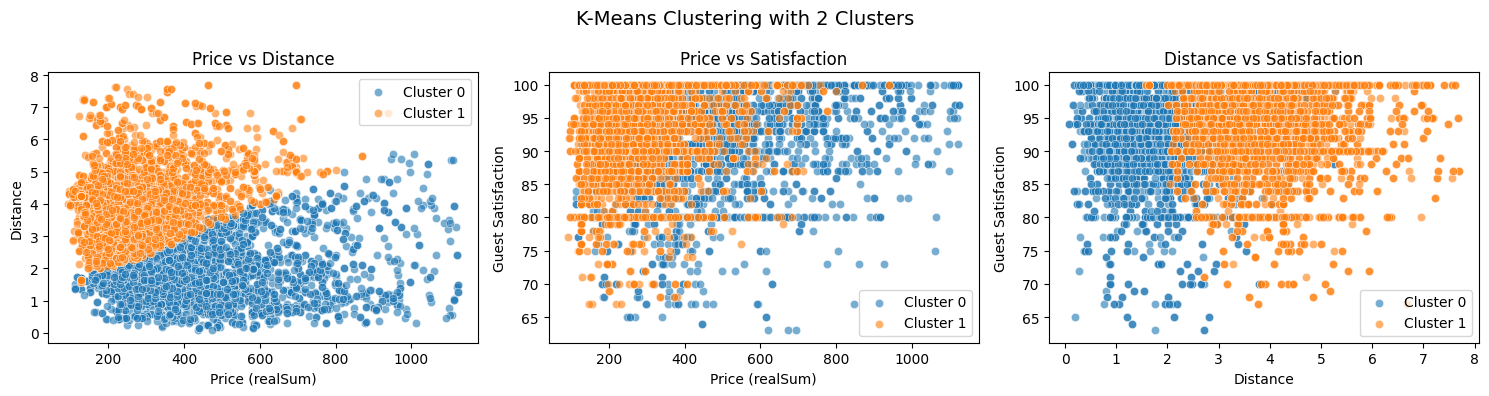

In [101]:
visualize_clusters(paris_all_clean, 'cluster_2', 'K-Means Clustering with 2 Clusters')

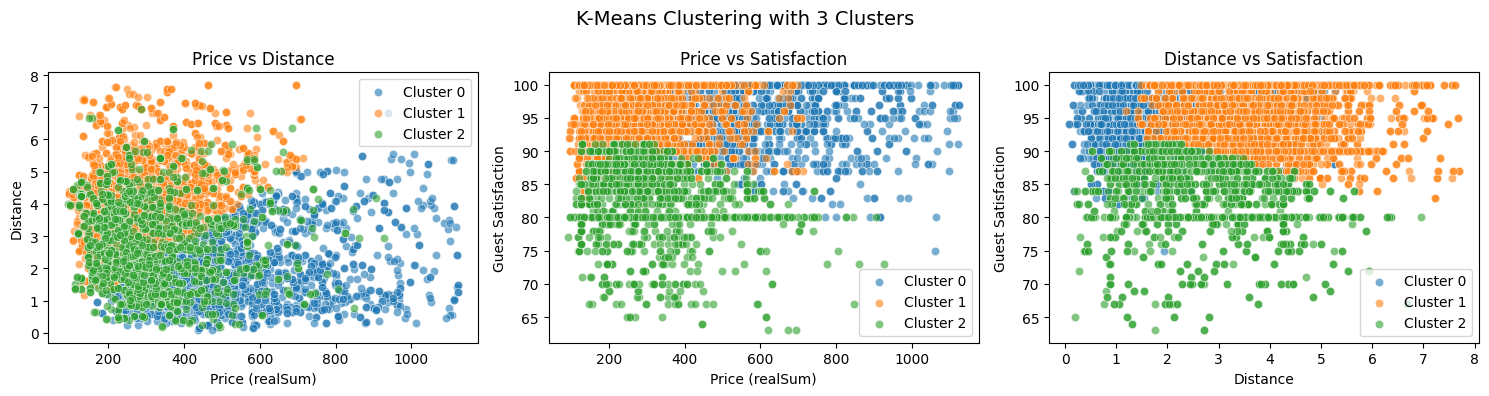

In [102]:
visualize_clusters(paris_all_clean, 'cluster_3', 'K-Means Clustering with 3 Clusters')

In [104]:
def visualize_clusters_3d(data, cluster_column, title):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    unique_clusters = sorted(data[cluster_column].unique())

    for cluster in unique_clusters:
        cluster_data = data[data[cluster_column] == cluster]
        ax.scatter(
            cluster_data['realSum'],
            cluster_data['dist'],
            cluster_data['guest_satisfaction_overall'],
            label=f'Cluster {cluster}',
            alpha=0.6,
            s=30,
            edgecolors='white',
            linewidth=0.5
        )

    ax.set_xlabel('Price (realSum)')
    ax.set_ylabel('Distance')
    ax.set_zlabel('Guest Satisfaction')
    ax.set_title(title)
    ax.legend(loc='upper left', framealpha=0.9)

    plt.tight_layout()
    plt.show()

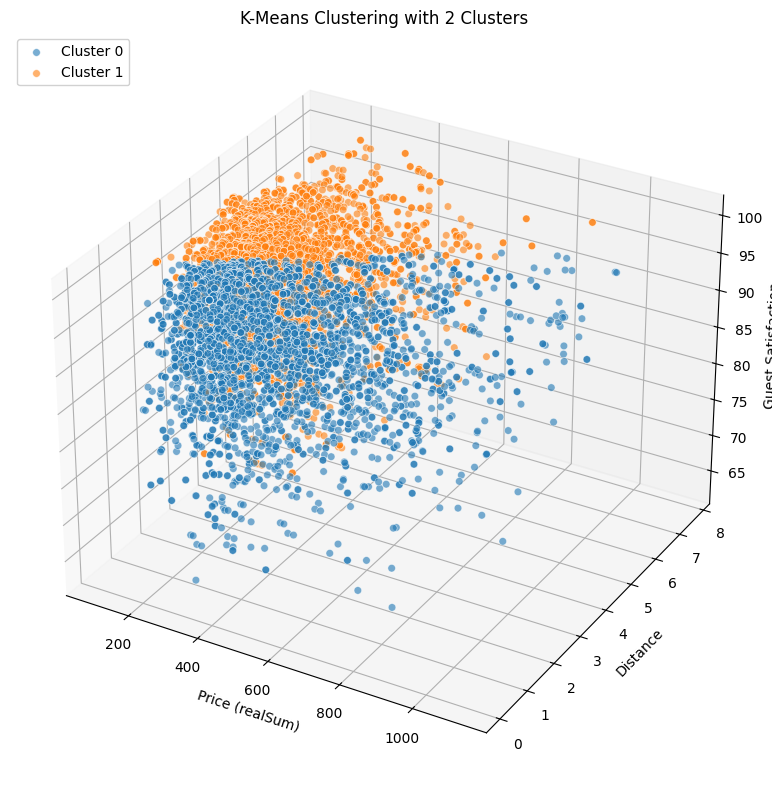

In [105]:
visualize_clusters_3d(paris_all_clean, 'cluster_2', 'K-Means Clustering with 2 Clusters')

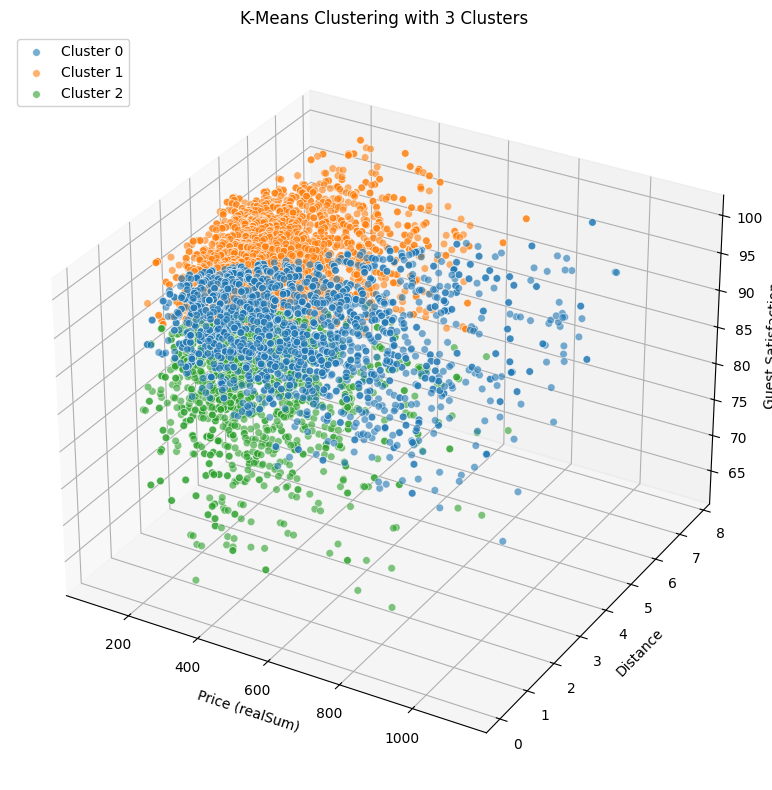

In [106]:
visualize_clusters_3d(paris_all_clean, 'cluster_3', 'K-Means Clustering with 3 Clusters')